# Flux of Mn across boundaries

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from itertools import compress
import datetime as dt
from datetime import date
import seaborn as sns; sns.set()
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

###### Parameters:

In [2]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800
isize = imax-imin
jsize = jmax-jmin

# model result set:
folder_ref      = '/data/brogalla/run_storage/Mn-reference-202103/'
folder_cleanice = '/data/brogalla/run_storage/Mn-clean-ice-202103/'
folder_spm      = '/data/brogalla/run_storage/Mn-spm-202103/'

# Colors:
dirty  = '#90a1b1'
clean  = '#cee7fd'
rivers = '#519e98'
colors = ['#ccb598', '#448d90', '#739f78', '#CC8741', '#cee7fd', '#b9c1c7']

In [3]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, \
         2016, 2017, 2018, 2019]

###### Load files:

In [4]:
mesh      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mesh.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
lons      = np.array(mesh.variables['nav_lon'])
lats      = np.array(mesh.variables['nav_lat'])

##### Functions:

In [5]:
def time_series_pickle(year, nosed=False, rivers=False):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # Load calculated time series of fluxes:
    if nosed:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder}Mn-clean-ice-202103/time-series-{year}.pickle','rb'))  
    elif rivers:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(f'{folder}Mn-spm-202103/time-series-{year}.pickle','rb'))  
    else:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
                pickle.load(open(f'{folder}Mn-reference-202103/time-series-{year}.pickle','rb'))
    
    return time_series_mn2, time_series_mn11

In [6]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1 = np.sort(os.listdir(f'{folder_ref}ref-{year}-202103/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

#### Calculations:

In [7]:
exp1_in  = np.empty((len(years),72,50,79)); exp1_out = np.empty((len(years),72,50,52)); # ref
exp2_in  = np.empty((len(years),72,50,79)); exp2_out = np.empty((len(years),72,50,52)); # nosed
exp3_in  = np.empty((len(years),72,50,79)); exp3_out = np.empty((len(years),72,50,52)); # rivers

for i, year in enumerate(years):
    ts_in1, ts_out1 = time_series_pickle(year)
    ts_in2, ts_out2 = time_series_pickle(year, nosed=True)
    ts_in3, ts_out3 = time_series_pickle(year, rivers=True)
    
    exp1_in[i,:,:,:]  = ts_in1
    exp2_in[i,:,:,:]  = ts_in2
    exp3_in[i,:,:,:]  = ts_in3
    exp1_out[i,:,:,:] = ts_out1
    exp2_out[i,:,:,:] = ts_out2
    exp3_out[i,:,:,:] = ts_out3

In [8]:
dates = np.array([])
for year in range(2002, 2020):
    dates = np.append(dates, file_dates(year))

In [9]:
Parry_ref_cumsumin  = np.cumsum(np.sum(-1*exp1_in, axis=(2,3)).flatten())
Parry_ref_cumsumout = np.cumsum(np.sum(-1*exp1_out, axis=(2,3)).flatten())

Parry_ref_in  = np.sum(-1*exp1_in, axis=(2,3)).flatten()
Parry_ref_out = np.sum(-1*exp1_out, axis=(2,3)).flatten()

Parry_ref_diff = Parry_ref_out - Parry_ref_in

In [10]:
Parry_nosed_cumsumin  = np.cumsum(np.sum(-1*exp2_in, axis=(2,3)).flatten())
Parry_nosed_cumsumout = np.cumsum(np.sum(-1*exp2_out, axis=(2,3)).flatten())

Parry_nosed_in  = np.sum(-1*exp2_in, axis=(2,3)).flatten()
Parry_nosed_out = np.sum(-1*exp2_out, axis=(2,3)).flatten()

Parry_nosed_diff = Parry_nosed_out - Parry_nosed_in

In [11]:
Parry_rivers_cumsumin  = np.cumsum(np.sum(-1*(exp3_in), axis=(2,3)).flatten())
Parry_rivers_cumsumout = np.cumsum(np.sum(-1*(exp3_out), axis=(2,3)).flatten())

Parry_rivers_in  = np.sum(-1*(exp3_in), axis=(2,3)).flatten()
Parry_rivers_out = np.sum(-1*(exp3_out), axis=(2,3)).flatten()

Parry_rivers_diff = Parry_rivers_out - Parry_rivers_in

### Figures

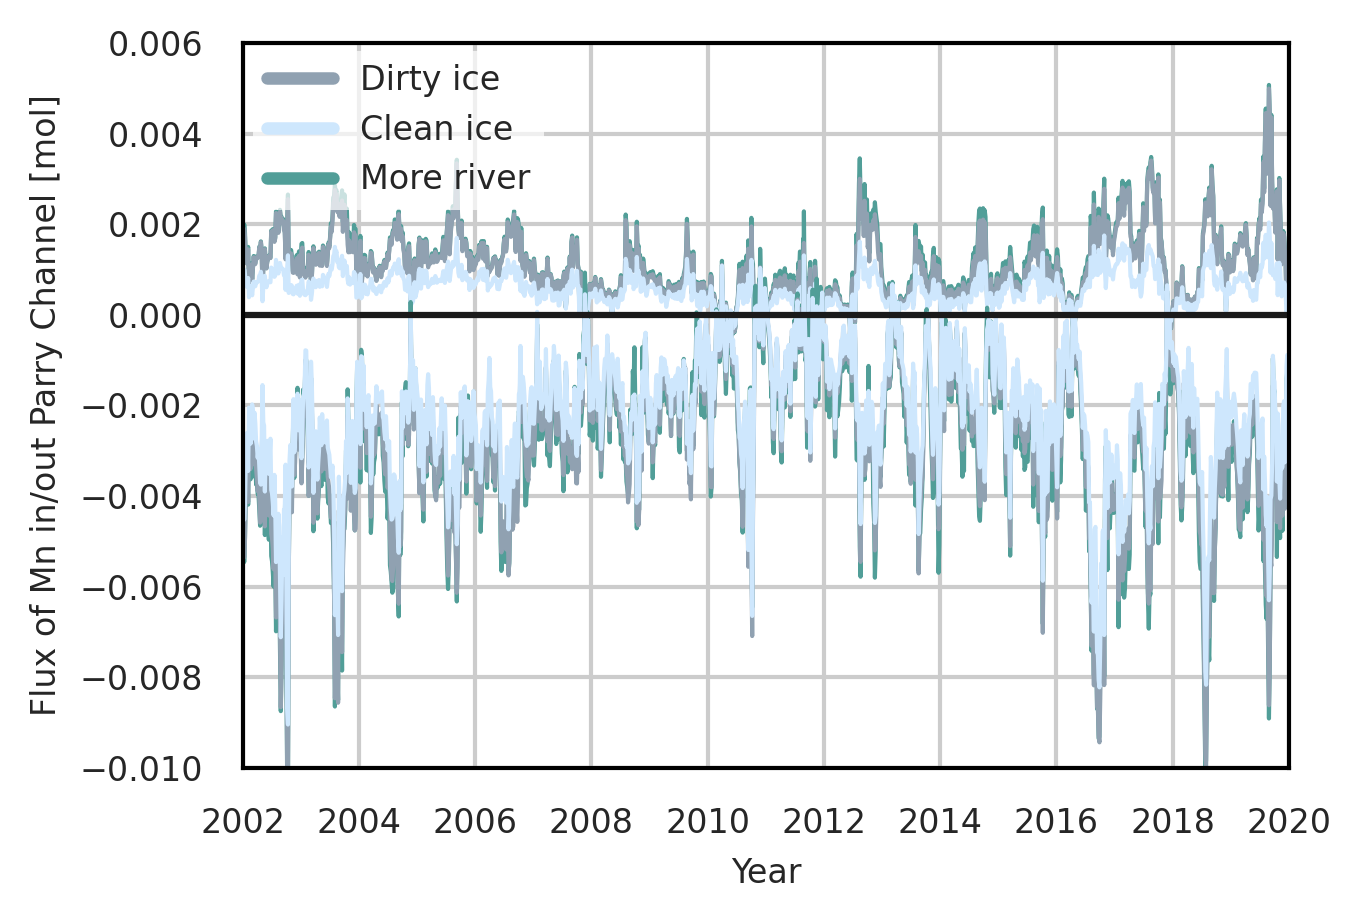

In [27]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, Parry_rivers_in,    linewidth=1.0, color=rivers, markersize=7)
    sns.lineplot(dates,      Parry_ref_in,       linewidth=1.0, color=dirty)
    sns.lineplot(dates,      Parry_nosed_in,     linewidth=1.0, color=clean, markersize=7)
    sns.lineplot(dates,      -1*Parry_rivers_out, linewidth=1.0, color=rivers)
    sns.lineplot(dates,      -1*Parry_ref_out,   linewidth=1.0, color=dirty)
    sns.lineplot(dates,      -1*Parry_nosed_out, linewidth=1.0, color=clean)
    
    sns.lineplot(dates[0],[0], linewidth=3, color=dirty, label=r'Dirty ice')
    sns.lineplot(dates[0],[0], linewidth=3, color=clean, label=r'Clean ice')
    sns.lineplot(dates[0],[0], linewidth=3, color=rivers, label=r'More river')

    sns.lineplot([dt.datetime(2002,1,1), dt.datetime(2020,1,1)], [0,0], c='k')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Flux of Mn in/out Parry Channel [mol]',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(-0.01, 0.006))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.0);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.0); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.0);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.0);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.01, 0.77), frameon=True, framealpha=0.7, fontsize=8)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S13-flux-timeseries.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S13-flux-timeseries.svg', bbox_inches='tight', dpi=300, \
#             format='svg')

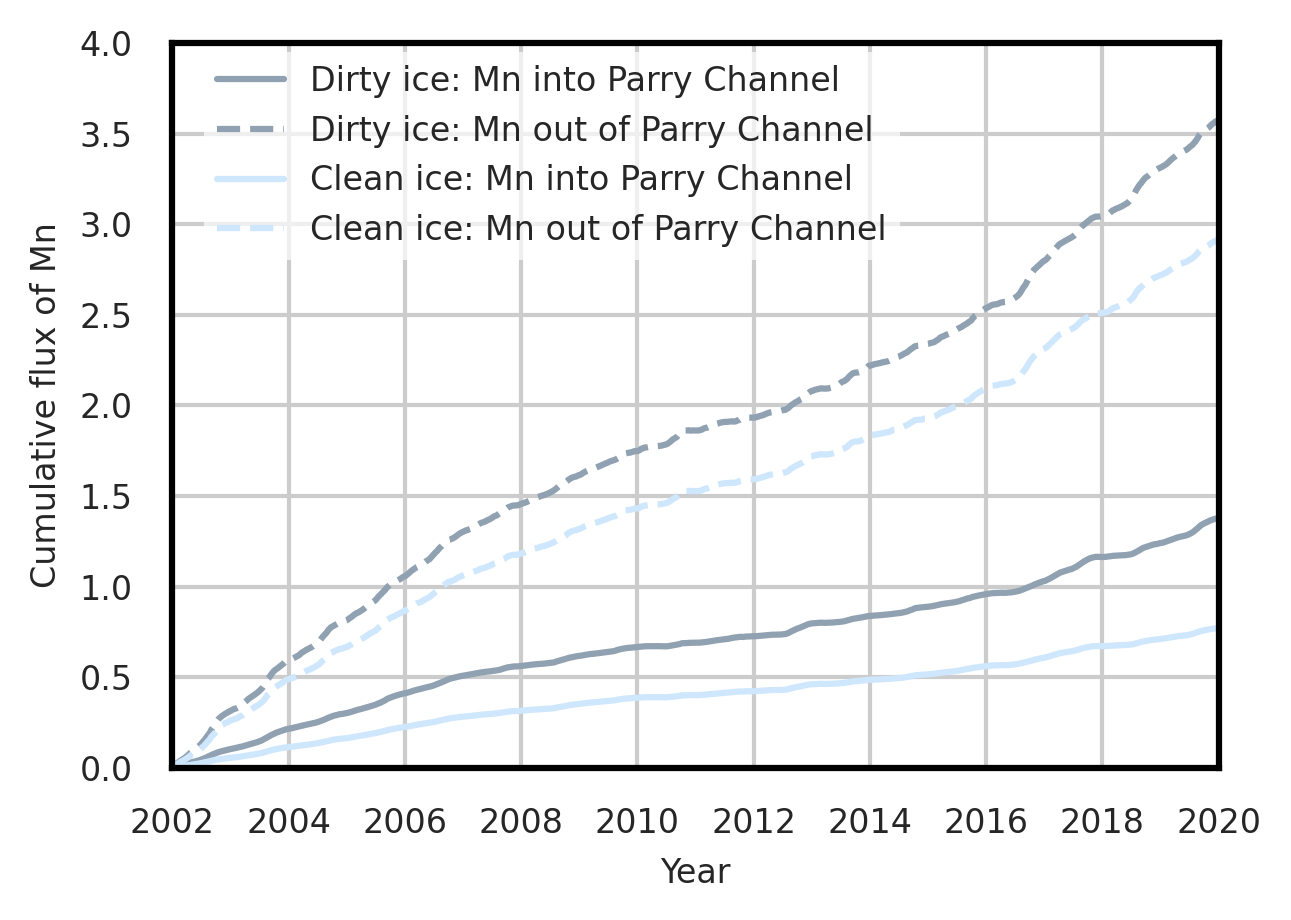

In [23]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, Parry_ref_cumsumin, linewidth=1.5, color=dirty, \
                      label=r'Dirty ice: Mn into Parry Channel')
    sns.lineplot(dates, Parry_ref_cumsumout, linewidth=1.5, color=dirty, \
                 label=r'Dirty ice: Mn out of Parry Channel')
    ax.lines[1].set_linestyle('--')
    
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], Parry_nosed_cumsumin, linewidth=1.5, color=clean, \
                 label=r'Clean ice: Mn into Parry Channel')
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], Parry_nosed_cumsumout, linewidth=1.5, color=clean, \
                 label=r'Clean ice: Mn out of Parry Channel')
    ax.lines[3].set_linestyle('--')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Cumulative flux of Mn',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 4.0))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.03, 0.7), frameon=True, framealpha=0.7, fontsize=8)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/D2-Mn-flux-'+ \
#             str(date.today().strftime('%Y%m%d')) + '.png', bbox_inches='tight',dpi=300)

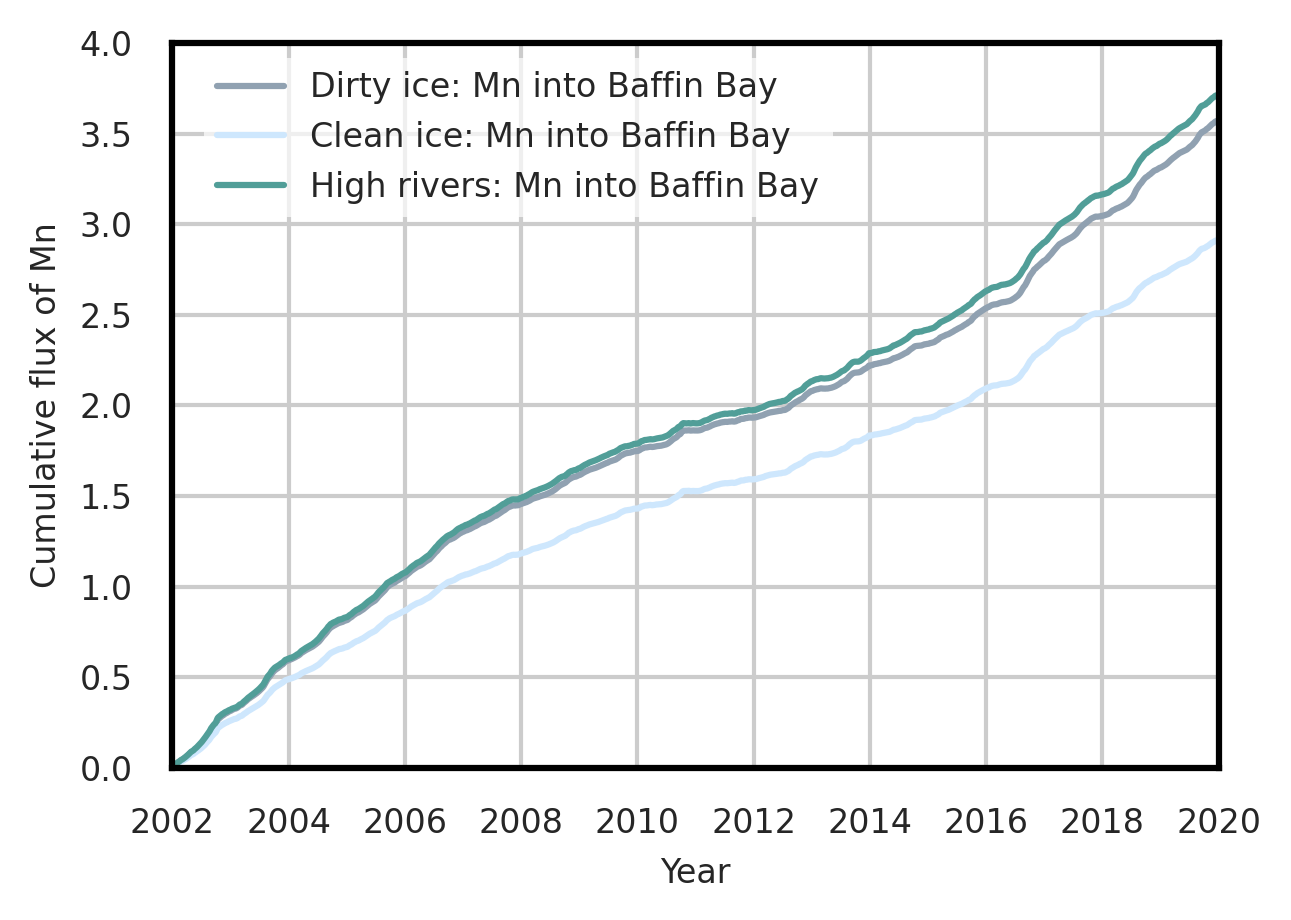

In [37]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates, Parry_ref_cumsumout, linewidth=1.5, color=dirty, \
                      label=r'Dirty ice: Mn into Baffin Bay')
    
    sns.lineplot(dates[0:Parry_nosed_out.shape[0]], Parry_nosed_cumsumout, linewidth=1.5, color=clean, \
                 label=r'Clean ice: Mn into Baffin Bay')
    sns.lineplot(dates[0:Parry_rivers_out.shape[0]], Parry_rivers_cumsumout, linewidth=1.5, color=rivers, \
                 label=r'High rivers: Mn into Baffin Bay')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Cumulative flux of Mn',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 4.0))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.03, 0.76), frameon=True, framealpha=0.7, fontsize=8)
    leg.get_frame().set_linewidth(0.0)

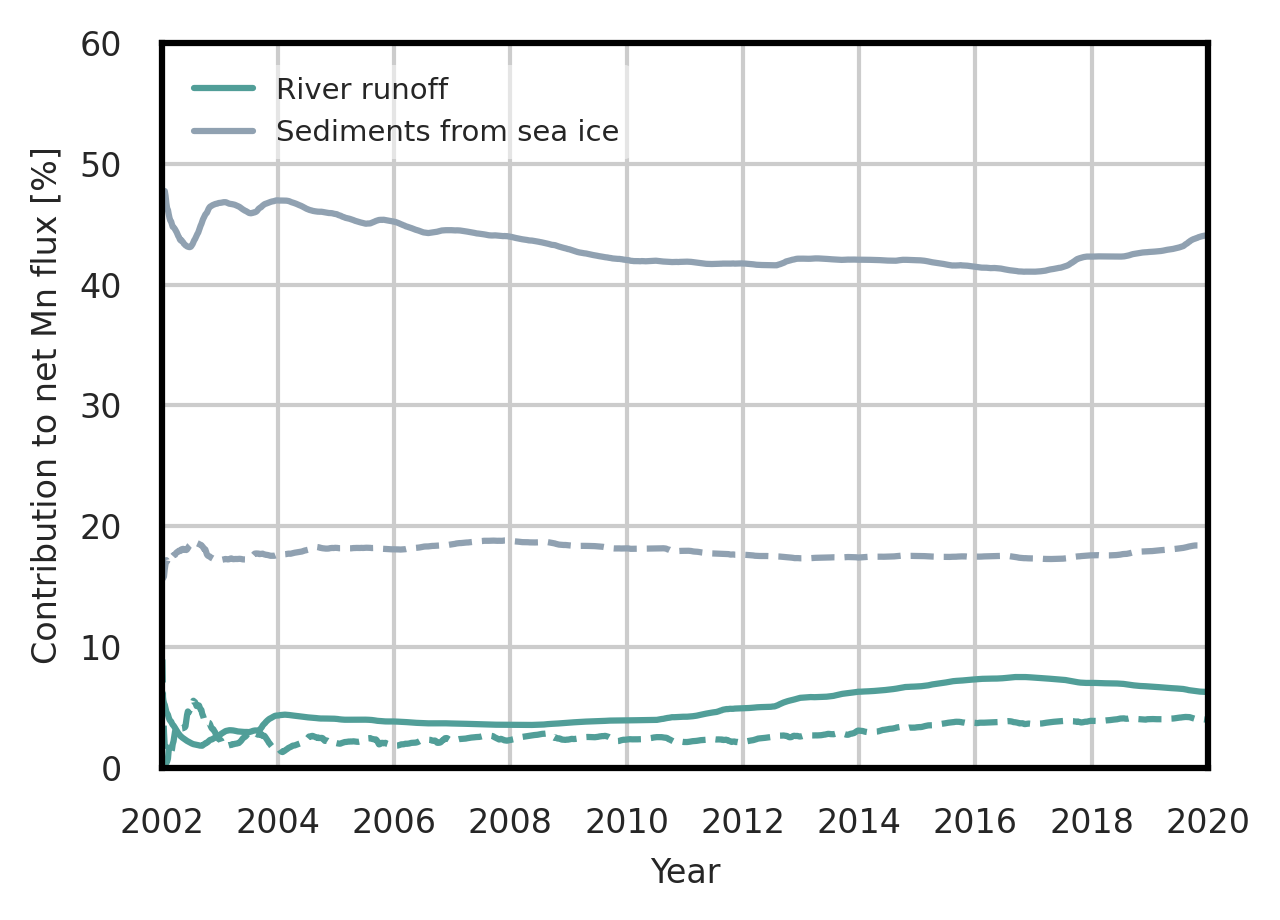

In [35]:
fig = plt.figure(figsize=(4.5, 3.2), dpi=300)
st  = sns.axes_style("whitegrid")

with st:
    ax = sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                      (1-np.divide(Parry_nosed_cumsumin, Parry_ref_cumsumin[0:Parry_nosed_in.shape[0]]))*100, \
                      linewidth=1.5, color=dirty)
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                 (1-np.divide(Parry_nosed_cumsumout, Parry_ref_cumsumout[0:Parry_nosed_in.shape[0]]))*100, \
                 linewidth=1.5, color=dirty)
    sns.lineplot(dates[0:Parry_ref_in.shape[0]], \
                      -1*(1-np.divide(Parry_rivers_cumsumin, Parry_ref_cumsumin[0:Parry_ref_in.shape[0]]))*100, \
                      linewidth=1.5, color=rivers)
    sns.lineplot(dates[0:Parry_ref_in.shape[0]], \
                 -1*(1-np.divide(Parry_rivers_cumsumout, Parry_ref_cumsumout[0:Parry_ref_in.shape[0]]))*100, \
                 linewidth=1.5, color=rivers)
    ax.lines[1].set_linestyle('--')
    ax.lines[3].set_linestyle('--')
    
    sns.lineplot(dates[0], [0], linewidth=1.5, color=rivers, label='River runoff')
    sns.lineplot(dates[0], [0], linewidth=1.5, color=dirty, label='Sediments from sea ice')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Contribution to net Mn flux [%]',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 60))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black'); 
    
    leg = ax.legend(loc=(0.02, 0.84), frameon=True, framealpha=0.5, fontsize=7)
    leg.get_frame().set_linewidth(0.0)
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S14-flux-percentage.png', bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202110/S14-flux-percentage.svg', bbox_inches='tight', dpi=300, \
#             format='svg')

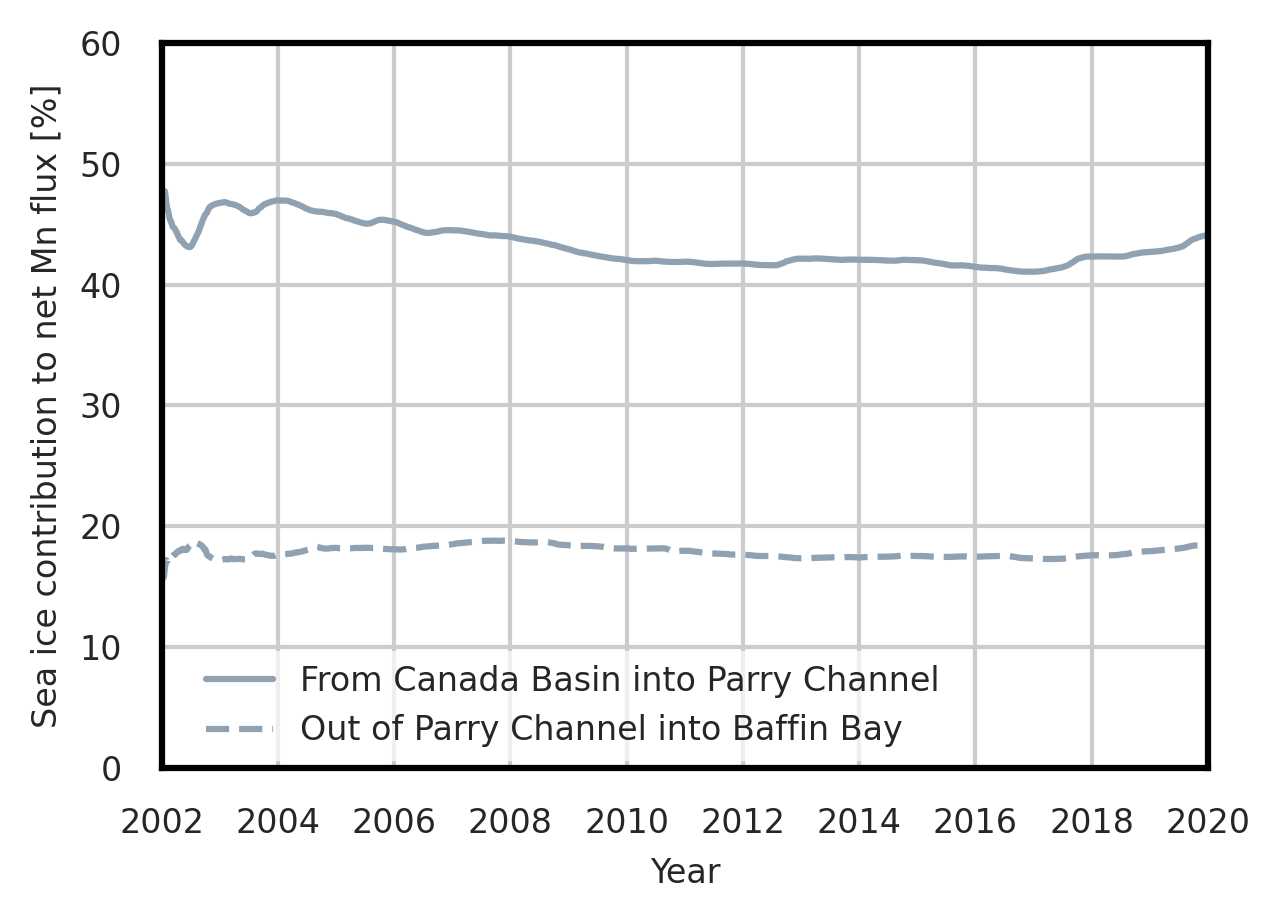

In [33]:
st  = sns.axes_style("whitegrid")

with st:
    fig = plt.figure(figsize=(4.5, 3.2), dpi=300)

    ax = sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                      (1-np.divide(Parry_nosed_cumsumin, Parry_ref_cumsumin[0:Parry_nosed_in.shape[0]]))*100, \
                      linewidth=1.5, color=dirty, label=r'From Canada Basin into Parry Channel')
    sns.lineplot(dates[0:Parry_nosed_in.shape[0]], \
                 (1-np.divide(Parry_nosed_cumsumout, Parry_ref_cumsumout[0:Parry_nosed_in.shape[0]]))*100, \
                 linewidth=1.5, color=dirty, label=r'Out of Parry Channel into Baffin Bay')
    ax.lines[1].set_linestyle('--')
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Sea ice contribution to net Mn flux [%]',fontsize=8)
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2020,1,1)), ylim=(0, 60))
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');    
    
    leg = ax.legend(loc=(0.03, 0.01), frameon=True, framealpha=0.7, fontsize=8)
    leg.get_frame().set_linewidth(0.0)
 
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/A9-flux-percentage.png', bbox_inches='tight', dpi=300)